In [ ]:
# ============================= PATH SETUP =============================
# Choose ONE of the following blocks depending on where you run the notebook.
# ------------------------------------------------------------------------------

from pathlib import Path
import sys

# ------------------------------------------------------------------------------
# OPTION A — Google Colab
# ------------------------------------------------------------------------------
# If you are running on Google Colab, UNCOMMENT this block.

"""
from google.colab import drive
drive.mount("/content/drive")

ROOT = Path("/content/drive/MyDrive/mbrl-testing-frameworks-empirical-study")
"""

# ------------------------------------------------------------------------------
# OPTION B — Local machine (GitHub clone)
# ------------------------------------------------------------------------------
# If you are running locally (e.g., after `git clone`), UNCOMMENT this block.

ROOT = Path("mbrl-testing-frameworks-empirical-study")

# ------------------------------------------------------------------------------
# Shared paths (DO NOT EDIT BELOW)
# ------------------------------------------------------------------------------

AGENT_ROOT  = ROOT / "agents" / "muzero" / "connect4"
RESULTS_DIR = ROOT / "results" / "connect4"
TABLES_DIR  = RESULTS_DIR / "tables"
FIGS_DIR    = RESULTS_DIR / "figs"
RAW_DIR     = RESULTS_DIR / "raw_single"

RESULTS_DIR.mkdir(parents=True, exist_ok=True)
TABLES_DIR.mkdir(parents=True, exist_ok=True)
FIGS_DIR.mkdir(parents=True, exist_ok=True)
RAW_DIR.mkdir(parents=True, exist_ok=True)

if str(AGENT_ROOT) not in sys.path:
    sys.path.insert(0, str(AGENT_ROOT))

print("AGENT_ROOT :", AGENT_ROOT)
print("RESULTS_DIR:", RESULTS_DIR)

Mounted at /content/drive
AGENT_ROOT : /content/drive/MyDrive/mbrl-testing-frameworks-empirical-study/agents/muzero/connect4
RESULTS_DIR: /content/drive/MyDrive/mbrl-testing-frameworks-empirical-study/results/connect4


In [ ]:
import os, sys, json, math, random
import numpy as np
import pandas as pd
from pathlib import Path
from time import perf_counter
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
from time import perf_counter

In [ ]:
# Global configuration
# ============================================================

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# Budget
# ============================================================
TEST_BUDGET = 100 #We reduce it for faster excution. to run the original setting and reproduce our paper results, change it to 1500

RESULTS_DIR.mkdir(parents=True, exist_ok=True)
CFG = {
    "env": "Connect4",
    "horizon": 84,
    "seed": 42,
    "budget_tests_default": 100
}


In [ ]:
# MuZero-General import
# ============================================================

import importlib

LOCAL_MUZERO = Path("external/muzero-general")

if not LOCAL_MUZERO.exists():
    !git clone --depth=1 https://github.com/werner-duvaud/muzero-general.git external/muzero-general

sys.path.insert(0, str(LOCAL_MUZERO))

import games.connect4 as games
models = importlib.import_module("models")

print("✓ MuZero-General loaded")


Cloning into 'external/muzero-general'...
remote: Enumerating objects: 47, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 47 (delta 11), reused 34 (delta 11), pack-reused 0 (from 0)
Receiving objects: 100% (47/47), 2.52 MiB | 8.68 MiB/s, done.
Resolving deltas: 100% (11/11), done.
✓ MuZero-General loaded


In [ ]:
# ============================================================
# Load fixed MuZero agent (pre-trained, no learning)
# ============================================================

import torch
torch.set_grad_enabled(False)

TDIR = AGENT_ROOT

COMP_DIR = TDIR / "components"
PLAN_DIR = TDIR / "planning"
TRAJ_DIR = TDIR / "trajectories"

assert COMP_DIR.exists(), "Missing agent components"

def make_config():
    try:
        return games.MuZeroConfig()
    except TypeError:
        return games.MuZeroConfig

def make_network(cfg):
    for name in ("MuZeroNetwork","Network","ResidualNetwork","ResNet"):
        if hasattr(models, name):
            net = getattr(models, name)(cfg)
            if hasattr(net, "initial_inference"):
                return net
    raise RuntimeError("No suitable MuZero network found")

def _strip(sd, prefixes):
    for p in prefixes:
        out = {k[len(p):]:v for k,v in sd.items() if k.startswith(p)}
        if out:
            return out
    return sd

agent_cfg = json.loads((COMP_DIR/"config.json").read_text())

cfg = make_config()
cfg.channels = agent_cfg["channels"]
cfg.blocks   = agent_cfg["blocks"]
cfg.action_space_size = 7
cfg.observation_shape = (3,6,7)

NET = make_network(cfg)

NET.representation_network.load_state_dict(
    _strip(torch.load(COMP_DIR/"representation.pt", map_location="cpu"),
           ["representation_network.","model.representation_network."]),
    strict=False)

NET.dynamics_network.load_state_dict(
    _strip(torch.load(COMP_DIR/"dynamics.pt", map_location="cpu"),
           ["dynamics_network.","model.dynamics_network."]),
    strict=False)

NET.prediction_network.load_state_dict(
    _strip(torch.load(COMP_DIR/"prediction.pt", map_location="cpu"),
           ["prediction_network.","model.prediction_network."]),
    strict=False)

NET.eval()
print("✓ Loaded MuZero agent")

✓ Loaded MuZero agent


In [ ]:
# ====  Connect-4 core, policy-guided action, stratified pool, final oracle ====
import torch, numpy as np, json, random
from pathlib import Path

# ----------------------- Connect-4 board -----------------------
ROWS, COLS = 6, 7

class C4:
    def __init__(self):
        self.board = np.zeros((ROWS, COLS), dtype=np.int8)
        self.player = 1
        self.done=False; self.winner=0; self.moves=0
    def clone(self):
        c=C4(); c.board[:]=self.board; c.player=self.player; c.done=self.done; c.winner=self.winner; c.moves=self.moves; return c
    def legal_actions(self):
        return [c for c in range(COLS) if self.board[0,c]==0]
    def step(self, a:int):
        if self.done: return
        ls = self.legal_actions()
        if a not in ls:
            self.done=True; self.winner=-self.player; return
        r=ROWS-1
        while r>=0 and self.board[r,a]!=0: r-=1
        self.board[r,a]=self.player; self.moves+=1
        if self._is_win(r,a): self.done=True; self.winner=self.player
        elif self.moves>=ROWS*COLS: self.done=True; self.winner=0
        else: self.player*=-1
    def _is_win(self,r,c):
        pl=self.player; b=self.board
        for dr,dc in [(1,0),(0,1),(1,1),(1,-1)]:
            cnt=1; rr,cc=r+dr,c+dc
            while 0<=rr<ROWS and 0<=cc<COLS and b[rr,cc]==pl: cnt+=1; rr+=dr; cc+=dc
            rr,cc=r-dr,c-dc
            while 0<=rr<ROWS and 0<=cc<COLS and b[rr,cc]==pl: cnt+=1; rr-=dr; cc-=dc
            if cnt>=4: return True
        return False
    def to_obs(self):
        # channel order consistent with muzero-general common configs
        ours  = (self.board== self.player).astype(np.float32)
        theirs= (self.board==-self.player).astype(np.float32)
        ones  = np.ones_like(ours, dtype=np.float32)
        return np.stack([ours,theirs,ones],axis=0)

# ----------------------- Test pool-----------------------
# Build a pool with early/mid/late strata to avoid skew (≈ 1/3 each)
EP_FILE = Path(AGENT_ROOT)/"trajectories"/"episodes.jsonl"

def _stones_filled(g: C4) -> int:
    return int(np.count_nonzero(g.board))

def _roll_selfplay_to_plies(target_plies_low, target_plies_high):
    g=C4()
    for _ in range(random.randint(target_plies_low, target_plies_high)):
        ls=g.legal_actions()
        if not ls: break
        g.step(random.choice(ls))
        if g.done: break
    return g

def _yield_from_episodes(max_take, ply_cap=None, ply_low=None, ply_high=None):
    got=[]
    if EP_FILE.exists():
        with open(EP_FILE,"r") as f:
            for line in f:
                if len(got) >= max_take: break
                try:
                    rec=json.loads(line)
                    moves = rec.get("moves") or rec.get("actions") or []
                    g=C4()
                    for mv_i, mv in enumerate(moves):
                        if g.done: break
                        if (ply_cap is not None and mv_i>ply_cap): break
                        g.step(int(mv))
                        take=True
                        if (ply_low is not None and mv_i < ply_low):  take=False
                        if (ply_high is not None and mv_i > ply_high): take=False
                        if take: got.append(g.clone())
                        if len(got) >= max_take: break
                except Exception:
                    pass
                if len(got) >= max_take: break
    return got

def build_pool_stratified(max_samples=5000, ratio=(1/3,1/3,1/3)):
    early_q, mid_q, late_q = ratio
    nE = int(max_samples*early_q); nM = int(max_samples*mid_q); nL = max_samples - nE - nM
    pool=[]

    # Early: 0–10 plies, from episodes (fast), fallback SP
    early = _yield_from_episodes(nE, ply_cap=10)
    while len(early)<nE:
        early.append(_roll_selfplay_to_plies(0,10))
    pool.extend(early[:nE])

    # Mid: 11–24 plies
    mid = _yield_from_episodes(nM, ply_low=11, ply_high=24)
    while len(mid)<nM:
        mid.append(_roll_selfplay_to_plies(11,24))
    pool.extend(mid[:nM])

    # Late: near-full boards (≥32 stones)
    late=[]
    # try episodes first
    if EP_FILE.exists():
        with open(EP_FILE,"r") as f:
            for line in f:
                if len(late)>=nL: break
                try:
                    rec=json.loads(line)
                    moves = rec.get("moves") or rec.get("actions") or []
                    g=C4()
                    for mv in moves:
                        if g.done: break
                        g.step(int(mv))
                    if _stones_filled(g) >= 32:
                        late.append(g.clone())
                except Exception:
                    pass
    # fill remainder by SP to late
    while len(late)<nL:
        g=_roll_selfplay_to_plies(26,42)
        if _stones_filled(g) >= 32: late.append(g)
    pool.extend(late[:nL])

    random.shuffle(pool)
    return pool[:max_samples]

TEST_POOL = build_pool_stratified(max_samples=5000, ratio=(1/3,1/3,1/3))
print("TEST_POOL stratified:", len(TEST_POOL))

# ----------------------- MuZero wrappers (policy + value) -----------------------
torch.set_grad_enabled(False)

def _ensure_4d(t):
    if t is None: return None
    if not torch.is_tensor(t):
        t = torch.tensor(np.array(t), dtype=torch.float32)
    if t.dim()==3: t = t.unsqueeze(0)
    elif t.dim()==2: t = t.unsqueeze(-1).unsqueeze(-1)
    elif t.dim()==1: t = t.view(1,-1,1,1)
    return t.contiguous()

def _softmax_np(x):
    x = np.asarray(x, dtype=np.float64)
    x = x - np.max(x)
    p = np.exp(x)
    s = p.sum()
    return (p / s) if s>0 else np.ones_like(p)/len(p)

def _float_safe(x, default=0.0):
    try:
        v=float(x);
        return default if (np.isnan(v) or np.isinf(v)) else v
    except Exception:
        return default

def _nanmean_safe(arr, default=0.0):
    try:
        a = np.asarray(arr)
        if a.dtype==object:
            a = a.astype(np.float32)
        m = np.nanmean(a)
        return default if (np.isnan(m) or np.isinf(m)) else float(m)
    except Exception:
        return default

def _reduce_to_len7(v_any):
    if v_any is None: return [0.0]*7
    v = np.asarray(v_any)
    if v.dtype==object:
        m=_nanmean_safe(v, 0.0); return [m]*7
    if v.ndim==0: return [_float_safe(v.item(),0.0)]*7
    for ax,dim in enumerate(v.shape):
        if dim==7:
            v2 = np.moveaxis(v, ax, 0)
            if v2.ndim==1: return [_float_safe(x,0.0) for x in v2.tolist()]
            return [_nanmean_safe(v2[i],0.0) for i in range(7)]
    vs = np.squeeze(v)
    if vs.ndim==1 and vs.shape[0]==7:
        try: vs = vs.astype(np.float32, copy=False)
        except: pass
        return [_float_safe(x,0.0) for x in vs.tolist()]
    m=_nanmean_safe(v,0.0); return [m]*7

@torch.inference_mode()
def muzero_initial_full(net, obs_np):

    obs_t = torch.tensor(obs_np[None,...], dtype=torch.float32)
    out = net.initial_inference(obs_t)
    hidden = getattr(out, "hidden_state", None)
    pol    = getattr(out, "policy_logits", None)
    val    = getattr(out, "value", None)
    if hidden is None or not torch.is_tensor(hidden):
        if hasattr(net,"representation"):         hidden = net.representation(obs_t)
        elif hasattr(net,"representation_network"): hidden = net.representation_network(obs_t)
        else: hidden = obs_t
    return {"hidden": _ensure_4d(hidden),
            "policy_logits": (pol.detach().cpu().numpy() if torch.is_tensor(pol) else pol),
            "value": (val.detach().cpu().numpy() if torch.is_tensor(val) else val)}

@torch.inference_mode()
def recurrent_values_all_actions(net, hidden):

    try:
        h = _ensure_4d(hidden)
        B,C,H,W = h.shape
        h7 = h.expand(7,C,H,W).contiguous()
        a7 = torch.arange(7, dtype=torch.long).view(7,1)  # [7,1]
        out = net.recurrent_inference(h7, a7)
        val = getattr(out, "value", None)
        v   = (val.detach().cpu().numpy() if torch.is_tensor(val) else val)
        vals = _reduce_to_len7(v)
        if len(vals)==7 and all(np.isfinite(vals)): return vals
    except Exception:
        pass
    vals=[]
    h1 = _ensure_4d(hidden)
    for a in range(7):
        try:
            out = net.recurrent_inference(h1, torch.tensor([[a]], dtype=torch.long))
            val = getattr(out, "value", None)
            v   = (val.detach().cpu().numpy() if torch.is_tensor(val) else val)
            vals.append(_nanmean_safe(v, 0.0))
        except Exception:
            vals.append(0.0)
    return vals

V_CACHE = {}
P_CACHE = {}

def state_key(g:C4): return (g.board.tobytes(), int(g.player))


def has_immediate_win(g:C4):
    for a in g.legal_actions():
        gc=g.clone(); gc.step(a)
        if gc.done and gc.winner==g.player: return True
    return False

def value_scores_for(g:C4):
    k=state_key(g)
    if k in V_CACHE: return V_CACHE[k]
    info = muzero_initial_full(NET, g.to_obs())
    vs = recurrent_values_all_actions(NET, info["hidden"])
    V_CACHE[k]=vs
    if info["policy_logits"] is not None:
        P_CACHE[k]=np.asarray(info["policy_logits"]).reshape(-1)
    return vs

def policy_logits_for(g:C4):
    k=state_key(g)
    if k in P_CACHE: return P_CACHE[k]
    info = muzero_initial_full(NET, g.to_obs())
    pol  = info["policy_logits"]
    if pol is None:
        pol = np.zeros(COLS, dtype=np.float32)
    pol = np.asarray(pol).reshape(-1)
    P_CACHE[k]=pol
    if k not in V_CACHE:
        V_CACHE[k]=recurrent_values_all_actions(NET, info["hidden"])
    return pol

# ----------------------- Oracle-----------------------
def side_has_immediate_win(g:C4):
    for a in g.legal_actions():
        gc=g.clone(); gc.step(a)
        if gc.done and gc.winner != 0:
            return True
    return False

def missed_immediate_win(g:C4, a:int) -> bool:
    ls = g.legal_actions();
    win_exists=False; chosen_is_win=False
    for cand in ls:
        gc=g.clone(); gc.step(cand)
        if gc.done and gc.winner==g.player:
            win_exists=True
            if cand==a: chosen_is_win=True
    return (win_exists and (not chosen_is_win))

def missed_immediate_block(g:C4, a:int) -> bool:
    opp_win_now = False
    for opp_a in g.legal_actions():
        gc=g.clone(); gc.step(opp_a)
        if gc.done and gc.winner != 0:
            opp_win_now = True; break
    if not opp_win_now:
        return False

    blocking_moves=set()
    for x in g.legal_actions():
        gx=g.clone(); gx.step(x)
        if not gx.done and (not side_has_immediate_win(gx)):  # opponent-to-move in gx
            blocking_moves.add(x)
    if blocking_moves:
        return (a not in blocking_moves)
    return False

def immediate_blunder(g:C4, a:int) -> bool:
    if a not in g.legal_actions(): return False
    s1=g.clone(); s1.step(a)
    if s1.done: return False
    return side_has_immediate_win(s1)

# ----------------------- Action selection (POLICY-guided) -----------------------
def choose_action_policy(g:C4, profile="CLEAN"):
    pol = policy_logits_for(g)
    eps, tau, logn = 0.0, None, None
    if profile=="MUT_AGENT/epsilon": eps=0.05
    elif profile=="MUT_AGENT/softmax": tau=0.75
    elif profile=="MUT_AGENT/logit": logn=0.25

    if eps>0 and (np.random.rand()<eps):
        return int(np.random.randint(0, COLS))

    logits = pol.astype(np.float64)
    if logn is not None:
        logits = logits + np.random.normal(0.0, logn, size=logits.shape)

    if tau is None or tau==1.0:
        a = int(np.argmax(logits))
    else:
        p = _softmax_np(logits / max(tau,1e-6))
        a = int(np.random.choice(np.arange(COLS), p=p))
    return a

# ----------------------- Evaluation with oracle -----------------------
def evaluate_set(states: list, profile="CLEAN"):
    rows=[]
    for i, g0 in enumerate(states[:TEST_BUDGET]):
        g = g0.clone()
        ls = g.legal_actions()

        a = choose_action_policy(g, profile=profile)
        illegal = int(a not in ls)

        failure = 0
        if illegal:
            failure = 1
        else:
            if missed_immediate_win(g, a):
                failure = 1
            elif missed_immediate_block(g, a):
                failure = 1
            elif immediate_blunder(g, a):
                failure = 1

        rows.append({"idx":i,"steps":1,"failure":int(failure),"illegal":illegal})
    return pd.DataFrame(rows)

# ----------------------- Metrics -----------------------
def metrics_from_rows(rows_df):
    df = rows_df.copy()
    df["failure"] = pd.to_numeric(df["failure"], errors="coerce").fillna(0).astype(int)
    df["steps"]   = pd.to_numeric(df["steps"], errors="coerce").fillna(1).astype(float)
    F = int(df["failure"].sum()); k = len(df)
    fr = float(df["failure"].mean())
    if F>0 and k>1:
        cum = df["failure"].cumsum().values
        apfd   = float(np.trapezoid(cum, x=np.arange(1,k+1)) / (F*k))
        T      = df["steps"].cumsum().values
        apfd_t = float(np.trapezoid(cum, x=T) / T[-1]) if T[-1]>0 else np.nan
        ttf    = float((df.index[df["failure"]==1][0] + 1))
    else:
        apfd=np.nan; apfd_t=np.nan; ttf=np.nan
    return df, {"FR":fr,"APFD":apfd,"APFD_time":apfd_t,"TTF":ttf}

def append_row(framework, profile, summary_dict, csv_path):
    base_cols = ["framework","profile","FR","TTF","APFD","APFD_time","MS","extra"]
    row = {k: "" for k in base_cols}
    row["framework"] = framework
    row["profile"]   = profile
    for k in ["FR","TTF","APFD","APFD_time","MS"]:
        v = summary_dict.get(k, "")
        if isinstance(v, float) and (math.isnan(v) or math.isinf(v)): v = ""
        row[k] = v
    extras = {k:v for k,v in summary_dict.items() if k not in row}
    row["extra"] = json.dumps(extras) if extras else ""
    write_header = not os.path.exists(csv_path)
    with open(csv_path, "a", newline="") as f:
        pd.DataFrame([row]).to_csv(f, index=False, header=write_header)
    print(f"[bench] wrote row for {framework} → {csv_path}")


def write_timing(dirpath, ttf_tests=None, ttf_seconds=None, total_seconds=None):
    os.makedirs(dirpath, exist_ok=True)
    with open(os.path.join(dirpath, "timing.json"), "w") as f:
        json.dump({
            "TTF_tests": float(ttf_tests) if ttf_tests is not None else None,
            "TTF_seconds": float(ttf_seconds) if ttf_seconds is not None else None,
            "total_seconds": float(total_seconds) if total_seconds is not None else None
        }, f, indent=2)

TEST_POOL stratified: 5000


In [ ]:
# ---- AdaStop  ----
FW="AdaStop"; FW_DIR=os.path.join(RESULTS_DIR,FW); os.makedirs(os.path.join(FW_DIR,"raw"), exist_ok=True)
states = random.sample(TEST_POOL, TEST_BUDGET)
start = perf_counter(); ttf_tests=None; ttf_sec=None
ad_df = evaluate_set(states, profile="CLEAN")
# first failure timings
fails_idx = ad_df.index[ad_df["failure"].astype(int)==1]
if len(fails_idx)>0:
    ttf_tests = int(fails_idx[0])+1
    ttf_sec   = perf_counter()-start
total_sec = perf_counter()-start
ad_df.to_csv(os.path.join(FW_DIR,"raw","adastop_agent_1500.csv"), index=False)
df,summ = metrics_from_rows(ad_df[["failure","steps"]])
summ["TTF_tests"]=float(ttf_tests) if ttf_tests is not None else np.nan
summ["TTF_seconds"]=float(ttf_sec) if ttf_sec is not None else np.nan
summ["total_seconds"]=float(total_sec)
write_timing(FW_DIR, ttf_tests, ttf_sec, total_sec)
append_row("AdaStop","CLEAN",summ,CLUSTER_C1)

[bench] wrote row for AdaStop → /content/drive/MyDrive/mbrl-testing-frameworks-empirical-study/results/connect4/tables/cluster_C1_metrics.csv


In [ ]:
# ---- F-Oracle ----
FW="F-Oracle"; FW_DIR=os.path.join(RESULTS_DIR,FW); os.makedirs(os.path.join(FW_DIR,"raw"), exist_ok=True)
rows=[]; start=perf_counter(); ttf_tests=None; ttf_sec=None
for i, g in enumerate(tqdm(random.sample(TEST_POOL, TEST_BUDGET), desc="F-Oracle")):
    ls=g.legal_actions(); mu=1.0
    if has_immediate_win(g):
        v = np.array(value_scores_for(g), dtype=np.float32); mask=np.full_like(v,-np.inf); mask[ls]=0
        a = int(np.argmax(v+mask))
        chosen_is_win=False
        for cand in ls:
            gc=g.clone(); gc.step(cand)
            if gc.done and gc.winner==g.player and cand==a: chosen_is_win=True
        mu = 1.0 if chosen_is_win else 0.0
    fail = int(1-mu)
    rows.append({"idx":i,"mu":mu,"steps":1,"failure":fail})
    if ttf_tests is None and fail==1:
        ttf_tests=i+1; ttf_sec=perf_counter()-start
total_sec=perf_counter()-start
fo_df = pd.DataFrame(rows)
fo_df.to_csv(os.path.join(FW_DIR,"raw","foracle_mu.csv"), index=False)
df,summ = metrics_from_rows(fo_df[["failure","steps"]])
summ["TTF_tests"]=float(ttf_tests) if ttf_tests else np.nan
summ["TTF_seconds"]=float(ttf_sec) if ttf_sec else np.nan
summ["total_seconds"]=float(total_sec)
write_timing(FW_DIR, ttf_tests, ttf_sec, total_sec)
append_row("F-Oracle","CLEAN",summ,CLUSTER_C1)

F-Oracle: 100%|██████████| 100/100 [00:18<00:00,  5.40it/s]

[bench] wrote row for F-Oracle → /content/drive/MyDrive/mbrl-testing-frameworks-empirical-study/results/connect4/tables/cluster_C1_metrics.csv


In [ ]:
# ---- CUSUM-RL ----
FW="CUSUM-RL"; FW_DIR=os.path.join(RESULTS_DIR,FW); os.makedirs(os.path.join(FW_DIR,"raw"), exist_ok=True)
rows=[]; start=perf_counter(); ttf_tests=None; ttf_sec=None
for i, g in enumerate(tqdm(random.sample(TEST_POOL, TEST_BUDGET), desc="CUSUM")):
    v = np.array(value_scores_for(g), dtype=np.float32); ls=g.legal_actions()
    mask=np.full_like(v,-np.inf); mask[ls]=0.0
    a = int(np.argmax(v+mask))
    failure = 0
    if has_immediate_win(g):
        chosen_is_win=False
        for cand in ls:
            gc=g.clone(); gc.step(cand)
            if gc.done and gc.winner==g.player and cand==a: chosen_is_win=True
        if not chosen_is_win: failure=1
    rows.append({"idx":i,"steps":1,"failure":failure})
    if ttf_tests is None and failure==1:
        ttf_tests=i+1; ttf_sec=perf_counter()-start
total_sec=perf_counter()-start
cu_df=pd.DataFrame(rows)
cu_df.to_csv(os.path.join(FW_DIR,"raw","cusum_canonical_1500.csv"), index=False)
df,summ = metrics_from_rows(cu_df[["failure","steps"]])
summ["TTF_tests"]=float(ttf_tests) if ttf_tests else np.nan
summ["TTF_seconds"]=float(ttf_sec) if ttf_sec else np.nan
summ["total_seconds"]=float(total_sec)
write_timing(FW_DIR, ttf_tests, ttf_sec, total_sec)
append_row("CUSUM-RL","CLEAN",summ,CLUSTER_C1)

CUSUM: 100%|██████████| 100/100 [00:32<00:00,  3.12it/s]

[bench] wrote row for CUSUM-RL → /content/drive/MyDrive/mbrl-testing-frameworks-empirical-study/results/connect4/tables/cluster_C1_metrics.csv


In [ ]:
# ---- DLBT ----
FW="DLBT"; FW_DIR=os.path.join(RESULTS_DIR,FW); os.makedirs(os.path.join(FW_DIR,"raw"), exist_ok=True)
rows=[]; start=perf_counter(); ttf_tests=None; ttf_sec=None
for i, g in enumerate(tqdm(random.sample(TEST_POOL, 750), desc="DLBT agent 750")):
    ls=g.legal_actions(); v=np.array(value_scores_for(g),dtype=np.float32)
    mask=np.full_like(v,-np.inf); mask[ls]=0.0
    a=int(np.argmax(v+mask))
    failure=0
    if has_immediate_win(g):
        chosen_is_win=False
        for cand in ls:
            gc=g.clone(); gc.step(cand)
            if gc.done and gc.winner==g.player and cand==a: chosen_is_win=True
        if not chosen_is_win: failure=1
    rows.append({"idx":i,"steps":1,"failure":failure})
    if ttf_tests is None and failure==1:
        ttf_tests=i+1; ttf_sec=perf_counter()-start
total_sec=perf_counter()-start
dl_df = pd.DataFrame(rows)
dl_df.to_csv(os.path.join(FW_DIR,"raw","agent_750.csv"), index=False)
df,summ = metrics_from_rows(dl_df[["failure","steps"]])
summ["TTF_tests"]=float(ttf_tests) if ttf_tests else np.nan
summ["TTF_seconds"]=float(ttf_sec) if ttf_sec else np.nan
summ["total_seconds"]=float(total_sec)
write_timing(FW_DIR, ttf_tests, ttf_sec, total_sec)
append_row("DLBT","CLEAN",summ,CLUSTER_C1)

DLBT agent 750: 100%|██████████| 750/750 [03:51<00:00,  3.23it/s]

[bench] wrote row for DLBT → /content/drive/MyDrive/mbrl-testing-frameworks-empirical-study/results/connect4/tables/cluster_C1_metrics.csv


In [ ]:
# ---- QD-Testing ----
from time import perf_counter

def bd_from_c4(g:C4):
    h=[]
    for c in range(COLS):
        col = g.board[:,c]
        height = ROWS - np.count_nonzero(col==0)
        h.append(height)
    def _threat_count(g):
        cnt=0; b=g.board; pl=g.player
        for r in range(ROWS):
            for c in range(COLS-3):
                w=b[r, c:c+4]
                if np.count_nonzero(w==pl)==3 and np.count_nonzero(w==0)==1: cnt+=1
        for r in range(ROWS-3):
            for c in range(COLS):
                w=b[r:r+4, c]
                if np.count_nonzero(w==pl)==3 and np.count_nonzero(w==0)==1: cnt+=1
        for r in range(ROWS-3):
            for c in range(COLS-3):
                w=np.diag(b[r:r+4, c:c+4])
                if np.count_nonzero(w==pl)==3 and np.count_nonzero(w==0)==1: cnt+=1
                w=np.diag(np.fliplr(b[r:r+4, c:c+4]))
                if np.count_nonzero(w==pl)==3 and np.count_nonzero(w==0)==1: cnt+=1
        return cnt
    return (tuple(h), _threat_count(g))
FRAME="QD-Testing"; FW_DIR=os.path.join(RESULTS_DIR,FRAME); os.makedirs(os.path.join(FW_DIR,"raw"), exist_ok=True)
archive={}; log=[]; start=perf_counter(); ttf_tests=None; ttf_sec=None
def score_from_g(g):
    v = np.array(value_scores_for(g), dtype=np.float32); ls=g.legal_actions()
    if len(ls)>=2:
        top = np.sort((v + np.where(np.isfinite(v),0,-np.inf))[ls])[-2:]
        margin = float(top[-1]-top[-2])
    else:
        margin = 0.0
    h,th = bd_from_c4(g)
    failure=0
    if has_immediate_win(g):
        mask=np.full_like(v,-np.inf); mask[ls]=0.0
        a=int(np.argmax(v+mask))
        chosen=False
        for cand in ls:
            gc=g.clone(); gc.step(cand)
            if gc.done and gc.winner==g.player and cand==a: chosen=True
        if not chosen: failure=1
    return (int(failure), th, -margin)

pool = random.sample(TEST_POOL, min(5000, len(TEST_POOL)))
for i in trange(200, desc="QD seed"):
    g = random.choice(pool).clone()
    sc = score_from_g(g)
    key = bd_from_c4(g)
    if (key not in archive) or (sc > archive[key]["score"]):
        archive[key]={"state":g.clone(),"score":sc}
    log.append({"idx":len(log),"steps":1,"failure":int(sc[0])})
    if ttf_tests is None and sc[0]==1:
        ttf_tests=len(log); ttf_sec=perf_counter()-start
while len(log) < TEST_BUDGET:
    base = random.choice(list(archive.values()))["state"].clone()
    g=base.clone()
    ls=g.legal_actions()
    if ls:
        g.step(random.choice(ls))
    sc=score_from_g(g); key=bd_from_c4(g)
    if (key not in archive) or (sc > archive[key]["score"]):
        archive[key]={"state":g.clone(),"score":sc}
    log.append({"idx":len(log),"steps":1,"failure":int(sc[0])})
    if ttf_tests is None and sc[0]==1:
        ttf_tests=len(log); ttf_sec=perf_counter()-start
total_sec=perf_counter()-start
qd_df = pd.DataFrame(log)
qd_df.to_csv(os.path.join(FW_DIR,"raw","qdtesting_seeds_1500.csv"), index=False)
df,summ = metrics_from_rows(qd_df[["failure","steps"]])
summ["TTF_tests"]=float(ttf_tests) if ttf_tests else np.nan
summ["TTF_seconds"]=float(ttf_sec) if ttf_sec else np.nan
summ["total_seconds"]=float(total_sec)
write_timing(FW_DIR, ttf_tests, ttf_sec, total_sec)
append_row("QD-Testing","CLEAN",summ,CLUSTER_C2)

QD seed: 100%|██████████| 200/200 [00:51<00:00,  3.85it/s]

[bench] wrote row for QD-Testing → /content/drive/MyDrive/mbrl-testing-frameworks-empirical-study/results/connect4/tables/cluster_C2_metrics.csv


In [ ]:
# ---- STARLA ----
FRAME="STARLA"; FW_DIR=os.path.join(RESULTS_DIR,FRAME); os.makedirs(os.path.join(FW_DIR,"raw"), exist_ok=True)
BUDGET=TEST_BUDGET; POP=100; GENS=max(1,BUDGET//POP)
def risk_proxy(g):
    v = np.array(value_scores_for(g), dtype=np.float32); ls=g.legal_actions()
    if len(ls)>=2:
        top = np.sort((v + np.where(np.isfinite(v),0,-np.inf))[ls])[-2:]
        gap = float(top[-1]-top[-2])
    else:
        gap=0.0
    h,th = bd_from_c4(g)
    return (1.0/(gap+1e-6) + 0.5*th)
def mutate_g(g:C4):
    g2=g.clone()
    if g2.legal_actions():
        g2.step(random.choice(g2.legal_actions()))
    return g2

pop = [random.choice(TEST_POOL).clone() for _ in range(POP)]
rows=[]; start=perf_counter(); ttf_tests=None; ttf_sec=None
for gen in trange(GENS, desc="STARLA gens"):
    scored = [{"fit": risk_proxy(g), "state": g} for g in pop]
    for g in pop:
        df = evaluate_set([g], profile="CLEAN")
        fail=int(df["failure"].iloc[0])
        rows.append({"idx":len(rows),"steps":1,"failure":fail})
        if ttf_tests is None and fail==1:
            ttf_tests=len(rows); ttf_sec=perf_counter()-start
    scored.sort(key=lambda x: x["fit"], reverse=True)
    parents = [x["state"] for x in scored[:max(1, POP//2)]]
    off=[]
    while len(off) < (POP-len(parents)):
        base = random.choice(parents)
        off.append(mutate_g(base))
    pop = parents + off
    if len(rows) >= BUDGET: break
total_sec=perf_counter()-start
starla_df = pd.DataFrame(rows[:BUDGET])
starla_df.to_csv(os.path.join(FW_DIR,"raw","starla_seeds_1500.csv"), index=False)
df,summ = metrics_from_rows(starla_df[["failure","steps"]])
summ["TTF_tests"]=float(ttf_tests) if ttf_tests else np.nan
summ["TTF_seconds"]=float(ttf_sec) if ttf_sec else np.nan
summ["total_seconds"]=float(total_sec)
write_timing(FW_DIR, ttf_tests, ttf_sec, total_sec)
append_row("STARLA","CLEAN",summ,CLUSTER_C2)

STARLA gens:   0%|          | 0/1 [00:32<?, ?it/s]

[bench] wrote row for STARLA → /content/drive/MyDrive/mbrl-testing-frameworks-empirical-study/results/connect4/tables/cluster_C2_metrics.csv


In [ ]:
# ---- Indago ----
FRAME="Indago"; FW_DIR=os.path.join(RESULTS_DIR,FRAME); os.makedirs(os.path.join(FW_DIR,"raw"), exist_ok=True)
try:
    from sklearn.ensemble import RandomForestClassifier
    HAVE_SK = True
except Exception:
    HAVE_SK = False

def rsample(pop, k):
    k = int(max(0, min(k, len(pop))))
    return random.sample(pop, k) if k > 0 else []

POOL  = min(6000, len(TEST_POOL))
TRAIN = min(1200, max(100, int(0.2*POOL)))
TOPK  = min(TEST_BUDGET, POOL)
pool_states = rsample(TEST_POOL, POOL)

def seed_features(g:C4):
    h,th = bd_from_c4(g)
    v = np.array(value_scores_for(g), dtype=np.float32); ls=g.legal_actions()
    if len(ls)>=2:
        top = np.sort((v + np.where(np.isfinite(v),0,-np.inf))[ls])[-2:]
        margin = float(top[-1]-top[-2])
    else:
        margin = 0.0
    return list(h)+[th, margin]

X_tr, y_tr = [], []
for g in tqdm(rsample(pool_states, TRAIN), desc="Indago label"):
    df = evaluate_set([g], profile="CLEAN")
    X_tr.append(seed_features(g)); y_tr.append(int(df["failure"].iloc[0]))
X_tr = np.array(X_tr); y_tr = np.array(y_tr)

if HAVE_SK and X_tr.shape[0]>=50 and (len(np.unique(y_tr))>=2):
    clf = RandomForestClassifier(n_estimators=300, random_state=CFG["seed"], class_weight="balanced_subsample")
    clf.fit(X_tr, y_tr)
    X_all = np.array([seed_features(g) for g in pool_states])
    scores = clf.predict_proba(X_all)[:,1]
else:
    def risk_seed(g):
        h,th = bd_from_c4(g)
        v = np.array(value_scores_for(g), dtype=np.float32); ls=g.legal_actions()
        if len(ls)>=2:
            top = np.sort((v + np.where(np.isfinite(v),0,-np.inf))[ls])[-2:]
            margin = float(top[-1]-top[-2])
        else:
            margin = 0.0
        return th + (1.0/(margin+1e-6))
    scores = np.array([risk_seed(g) for g in pool_states])

sel_idx = np.argsort(-scores)[:TOPK]
tests   = [pool_states[int(i)] for i in sel_idx]
tests   = tests[:TEST_BUDGET]
rows=[]; start=perf_counter(); ttf_tests=None; ttf_sec=None
for i, g in enumerate(tqdm(tests, desc="Indago eval")):
    df = evaluate_set([g], profile="CLEAN")
    fail = int(df["failure"].iloc[0])
    rows.append({"idx":i, "steps":1, "failure":fail})
    if ttf_tests is None and fail==1:
        ttf_tests=i+1; ttf_sec=perf_counter()-start
total_sec=perf_counter()-start

ind_df = pd.DataFrame(rows)
ind_df.to_csv(os.path.join(FW_DIR,"raw","indago_seeds_1500.csv"), index=False)
df, summ = metrics_from_rows(ind_df[["failure","steps"]])
summ["TTF_tests"]=float(ttf_tests) if ttf_tests is not None else np.nan
summ["TTF_seconds"]=float(ttf_sec) if ttf_sec is not None else np.nan
summ["total_seconds"]=float(total_sec)
write_timing(FW_DIR, ttf_tests, ttf_sec, total_sec)
append_row("Indago","CLEAN",summ,CLUSTER_C2)

Indago eval: 100%|██████████| 100/100 [00:02<00:00, 41.97it/s]

[bench] wrote row for Indago → /content/drive/MyDrive/mbrl-testing-frameworks-empirical-study/results/connect4/tables/cluster_C2_metrics.csv


In [ ]:
# ---- AlphaTest ----
FRAME="AlphaTest"; FW_DIR=os.path.join(RESULTS_DIR,FRAME); os.makedirs(os.path.join(FW_DIR,"raw"), exist_ok=True)
SLIP_GRID=[0.0,0.05,0.10,0.15]
NOISE_GRID=[0.0,0.10,0.20]
rows=[]; start=perf_counter(); ttf_tests=None; ttf_sec=None
while len(rows) < TEST_BUDGET:
    g = random.choice(TEST_POOL)
    tau = random.choice([0.5,0.75,1.0,1.25]) * (1.0 + random.choice(SLIP_GRID))
    logn= random.choice(NOISE_GRID)
    prof = "CLEAN"
    if logn>0.0: prof="MUT_AGENT/logit"
    elif tau!=1.0: prof="MUT_AGENT/softmax"
    df = evaluate_set([g], profile=prof)
    fail=int(df['failure'].iloc[0])
    rows.append({"idx":len(rows),"steps":1,"failure":fail})
    if ttf_tests is None and fail==1:
        ttf_tests=len(rows); ttf_sec=perf_counter()-start
total_sec=perf_counter()-start
al_df = pd.DataFrame(rows)
al_df.to_csv(os.path.join(FW_DIR,"raw","alphatest_1500.csv"), index=False)
df,summ = metrics_from_rows(al_df[["failure","steps"]])
summ["TTF_tests"]=float(ttf_tests) if ttf_tests else np.nan
summ["TTF_seconds"]=float(ttf_sec) if ttf_sec else np.nan
summ["total_seconds"]=float(total_sec)
write_timing(FW_DIR, ttf_tests, ttf_sec, total_sec)
append_row("AlphaTest","CLEAN",summ,CLUSTER_C2)

[bench] wrote row for AlphaTest → /content/drive/MyDrive/mbrl-testing-frameworks-empirical-study/results/connect4/tables/cluster_C2_metrics.csv


In [ ]:
# ---- NR-RL ----
FRAME="NR-RL"; NR_DIR=os.path.join(RESULTS_DIR,FRAME); os.makedirs(os.path.join(NR_DIR,"raw"), exist_ok=True)
def margin(g):
    v=np.array(value_scores_for(g),dtype=np.float32); ls=g.legal_actions()
    if len(ls)<2: return 0.0
    top=np.sort((v+np.where(np.isfinite(v),0,-np.inf))[ls])[-2:]
    return float(top[-1]-top[-2])

rows=[]; start=perf_counter(); ttf_tests=None; ttf_sec=None
for i,g in enumerate(tqdm(random.sample(TEST_POOL, TEST_BUDGET), desc="NR-RL")):
    m = margin(g); ls=g.legal_actions()
    v=np.array(value_scores_for(g),dtype=np.float32)
    mask=np.full_like(v,-np.inf); mask[ls]=0.0
    a_best=int(np.argmax(v+mask))
    a_2nd = int(np.argsort(v+mask)[-2]) if len(ls)>=2 else a_best
    a = a_2nd if (m<0.05) else a_best
    failure=0
    if has_immediate_win(g):
        chosen=False
        for cand in ls:
            gc=g.clone(); gc.step(cand)
            if gc.done and gc.winner==g.player and cand==a: chosen=True
        if not chosen: failure=1
    rows.append({"idx":i,"steps":1,"failure":failure})
    if ttf_tests is None and failure==1:
        ttf_tests=i+1; ttf_sec=perf_counter()-start
total_sec=perf_counter()-start
nr_df=pd.DataFrame(rows)
nr_df.to_csv(os.path.join(NR_DIR,"raw","act_worstq_p30.csv"), index=False)
df,summ = metrics_from_rows(nr_df[["failure","steps"]])
summ["TTF_tests"]=float(ttf_tests) if ttf_tests else np.nan
summ["TTF_seconds"]=float(ttf_sec) if ttf_sec else np.nan
summ["total_seconds"]=float(total_sec)
write_timing(NR_DIR, ttf_tests, ttf_sec, total_sec)
append_row("NR-RL","repr",summ,CLUSTER_C3)

NR-RL: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]

[bench] wrote row for NR-RL → /content/drive/MyDrive/mbrl-testing-frameworks-empirical-study/results/connect4/tables/cluster_C3_metrics.csv


In [ ]:
# ---- SBF ----
FRAME="SBF"; SBF_DIR=os.path.join(RESULTS_DIR,FRAME); os.makedirs(os.path.join(SBF_DIR,"raw"), exist_ok=True)
def is_boundary(g): return has_immediate_win(g)
B = [g.clone() for g in TEST_POOL if is_boundary(g)]
if not B: B = random.sample(TEST_POOL, min(200, len(TEST_POOL)))

def random_prefix(g):
    g2=g.clone(); L=random.randint(2,4)
    for _ in range(L):
        ls=g2.legal_actions()
        if not ls: break
        g2.step(random.choice(ls))
    return g2

rows=[]; start=perf_counter(); ttf_tests=None; ttf_sec=None
per = max(1, TEST_BUDGET//max(1,len(B)))
for b in B:
    for _ in range(per):
        cand = random_prefix(b)
        df = evaluate_set([cand], profile="CLEAN")
        fail=int(df["failure"].iloc[0])
        rows.append({"steps":1,"failure":fail})
        if ttf_tests is None and fail==1:
            ttf_tests=len(rows); ttf_sec=perf_counter()-start
        if len(rows)>=TEST_BUDGET: break
    if len(rows)>=TEST_BUDGET: break
while len(rows)<TEST_BUDGET:
    df = evaluate_set([random.choice(TEST_POOL)], profile="CLEAN")
    fail=int(df['failure'].iloc[0])
    rows.append({"steps":1,"failure":fail})
    if ttf_tests is None and fail==1:
        ttf_tests=len(rows); ttf_sec=perf_counter()-start
total_sec=perf_counter()-start
sbf_df=pd.DataFrame(rows)
sbf_df.to_csv(os.path.join(SBF_DIR,"raw","SBF_boundary.csv"), index=False)
df,summ = metrics_from_rows(sbf_df[["failure","steps"]])
summ["TTF_tests"]=float(ttf_tests) if ttf_tests else np.nan
summ["TTF_seconds"]=float(ttf_sec) if ttf_sec else np.nan
summ["total_seconds"]=float(total_sec)
write_timing(SBF_DIR, ttf_tests, ttf_sec, total_sec)
append_row("SBF","CLEAN",summ,CLUSTER_C3)

[bench] wrote row for SBF → /content/drive/MyDrive/mbrl-testing-frameworks-empirical-study/results/connect4/tables/cluster_C3_metrics.csv


In [ ]:
# ---- MDPFuzz ----
FRAME="MDPFuzz"; MDP_DIR=os.path.join(RESULTS_DIR,FRAME); os.makedirs(os.path.join(MDP_DIR,"raw"), exist_ok=True)
rows=[]; start=perf_counter(); ttf_tests=None; ttf_sec=None
for i in trange(TEST_BUDGET, desc="MDPFuzz"):
    g=random.choice(TEST_POOL).clone()
    for _ in range(random.randint(2,6)):
        ls=g.legal_actions()
        if not ls: break
        g.step(random.choice(ls))
    df = evaluate_set([g], profile="CLEAN")
    fail=int(df["failure"].iloc[0])
    rows.append({"idx":i,"steps":1,"failure":fail})
    if ttf_tests is None and fail==1:
        ttf_tests=i+1; ttf_sec=perf_counter()-start
total_sec=perf_counter()-start
mdp_df=pd.DataFrame(rows)
mdp_df.to_csv(os.path.join(MDP_DIR,"raw","mdpfuzz_1500.csv"), index=False)
df,summ = metrics_from_rows(mdp_df[["failure","steps"]])
summ["TTF_tests"]=float(ttf_tests) if ttf_tests else np.nan
summ["TTF_seconds"]=float(ttf_sec) if ttf_sec else np.nan
summ["total_seconds"]=float(total_sec)
write_timing(MDP_DIR, ttf_tests, ttf_sec, total_sec)
append_row("MDPFuzz","CLEAN",summ,CLUSTER_C3)

MDPFuzz: 100%|██████████| 100/100 [00:37<00:00,  2.66it/s]

[bench] wrote row for MDPFuzz → /content/drive/MyDrive/mbrl-testing-frameworks-empirical-study/results/connect4/tables/cluster_C3_metrics.csv


In [ ]:
# ---- pi-Fuzz ----
FRAME="pi-Fuzz"; PIF_DIR=os.path.join(RESULTS_DIR,FRAME); os.makedirs(os.path.join(PIF_DIR,"raw"), exist_ok=True)
rows=[]; start=perf_counter(); ttf_tests=None; ttf_sec=None
for i in trange(300, desc="pi-Fuzz bases"):
    g=random.choice(TEST_POOL).clone()
    hard=g.clone(); easy=g.clone()
    if hard.legal_actions(): hard.step(random.choice(hard.legal_actions()))
    if easy.legal_actions(): easy.step(random.choice(easy.legal_actions()))
    fh=int(evaluate_set([hard],"CLEAN")["failure"].iloc[0])
    fe=int(evaluate_set([easy],"CLEAN")["failure"].iloc[0])
    bug = 1 if (fh==0 and fe==1) else 0
    rows.append({"idx":len(rows),"steps":1,"failure":bug})
    if ttf_tests is None and bug==1:
        ttf_tests=len(rows); ttf_sec=perf_counter()-start
while len(rows)<TEST_BUDGET:
    rows.append({"idx":len(rows),"steps":1,"failure":0})
total_sec=perf_counter()-start
pif_df=pd.DataFrame(rows)
pif_df.to_csv(os.path.join(PIF_DIR,"raw","pifuzz_mr.csv"), index=False)
df,summ = metrics_from_rows(pif_df[["failure","steps"]])
summ["TTF_tests"]=float(ttf_tests) if ttf_tests else np.nan
summ["TTF_seconds"]=float(ttf_sec) if ttf_sec else np.nan
summ["total_seconds"]=float(total_sec)
write_timing(PIF_DIR, ttf_tests, ttf_sec, total_sec)
append_row("pi-Fuzz","CLEAN",summ,CLUSTER_C3)

pi-Fuzz bases: 100%|██████████| 300/300 [02:16<00:00,  2.19it/s]

[bench] wrote row for pi-Fuzz → /content/drive/MyDrive/mbrl-testing-frameworks-empirical-study/results/connect4/tables/cluster_C3_metrics.csv


In [ ]:
# ---- GMBT ----
FRAME="GMBT"; GMBT_DIR=os.path.join(RESULTS_DIR,FRAME); os.makedirs(os.path.join(GMBT_DIR,"raw"), exist_ok=True)
rows=[]; start=perf_counter(); ttf_tests=None; ttf_sec=None
for i in trange(TEST_BUDGET, desc="GMBT"):
    cand = random.sample(TEST_POOL, min(50, len(TEST_POOL)))
    best=None; best_gain=-1
    existing = set()
    for r in rows:
        existing.add(bd_from_c4(random.choice(TEST_POOL))[0])
    for g in cand:
        h,th = bd_from_c4(g)
        if existing:
            gain = min([np.linalg.norm(np.array(h)-np.array(eh)) for eh in existing]) + 0.25*th
        else:
            gain = 1e3
        if gain>best_gain: best=(g,h,th); best_gain=gain
    g=best[0]
    df = evaluate_set([g], "CLEAN")
    fail=int(df["failure"].iloc[0])
    rows.append({"idx":i,"steps":1,"failure":fail})
    if ttf_tests is None and fail==1:
        ttf_tests=i+1; ttf_sec=perf_counter()-start
total_sec=perf_counter()-start
gmbt_df=pd.DataFrame(rows)
gmbt_df.to_csv(os.path.join(GMBT_DIR,"raw","gmbt_1500.csv"), index=False)
df,summ = metrics_from_rows(gmbt_df[["failure","steps"]])
summ["TTF_tests"]=float(ttf_tests) if ttf_tests else np.nan
summ["TTF_seconds"]=float(ttf_sec) if ttf_sec else np.nan
summ["total_seconds"]=float(total_sec)
write_timing(GMBT_DIR, ttf_tests, ttf_sec, total_sec)
append_row("GMBT","CLEAN",summ,CLUSTER_C3)

GMBT: 100%|██████████| 100/100 [00:22<00:00,  4.48it/s]

[bench] wrote row for GMBT → /content/drive/MyDrive/mbrl-testing-frameworks-empirical-study/results/connect4/tables/cluster_C3_metrics.csv


In [ ]:
# ---- CureFuzz ----
FRAME="CureFuzz"; CF_DIR=os.path.join(RESULTS_DIR,FRAME); os.makedirs(os.path.join(CF_DIR,"raw"), exist_ok=True)
rows=[]; start=perf_counter(); ttf_tests=None; ttf_sec=None
seen=set()
for i in trange(TEST_BUDGET, desc="CureFuzz"):
    g=random.choice(TEST_POOL).clone()
    h,th=bd_from_c4(g)
    if h in seen and g.legal_actions():
        g.step(random.choice(g.legal_actions()))
        h,th=bd_from_c4(g)
    seen.add(h)
    df=evaluate_set([g],"CLEAN"); fail=int(df["failure"].iloc[0])
    rows.append({"idx":i,"steps":1,"failure":fail})
    if ttf_tests is None and fail==1:
        ttf_tests=i+1; ttf_sec=perf_counter()-start
total_sec=perf_counter()-start
cf_df=pd.DataFrame(rows)
cf_df.to_csv(os.path.join(CF_DIR,"raw","curefuzz_episodes.csv"), index=False)
df,summ=metrics_from_rows(cf_df[["failure","steps"]])
summ["TTF_tests"]=float(ttf_tests) if ttf_tests else np.nan
summ["TTF_seconds"]=float(ttf_sec) if ttf_sec else np.nan
summ["total_seconds"]=float(total_sec)
write_timing(CF_DIR, ttf_tests, ttf_sec, total_sec)
append_row("CureFuzz","CLEAN",summ,CLUSTER_C3)

CureFuzz: 100%|██████████| 100/100 [00:18<00:00,  5.48it/s]

[bench] wrote row for CureFuzz → /content/drive/MyDrive/mbrl-testing-frameworks-empirical-study/results/connect4/tables/cluster_C3_metrics.csv


In [ ]:
# ---- RLMutation (agent mutants interleaved) ----
FRAME="RLMutation"; RLM_DIR=os.path.join(RESULTS_DIR,FRAME); os.makedirs(os.path.join(RLM_DIR,"raw"), exist_ok=True)
mut_profiles = ["MUT_AGENT/epsilon","MUT_AGENT/softmax","MUT_AGENT/logit"]
streams = []; starts_time = perf_counter(); ttf_tests=None; ttf_sec=None

for prof in mut_profiles:
    df = evaluate_set(random.sample(TEST_POOL, TEST_BUDGET), profile=prof)
    df.to_csv(os.path.join(RLM_DIR,"raw",f"{prof.replace('/','_')}.csv"), index=False)
    df["profile"]=prof
    streams.append(df.reset_index(drop=True))

heads=[0,0,0]; agg=[]
while len(agg)<TEST_BUDGET:
    progressed=False
    for k in range(3):
        if heads[k] < len(streams[k]):
            r = streams[k].iloc[heads[k]].to_dict()
            r["idx"]=len(agg); agg.append(r); heads[k]+=1; progressed=True
            if len(agg)>=TEST_BUDGET: break
    if not progressed: break
df_all=pd.DataFrame(agg).iloc[:TEST_BUDGET].reset_index(drop=True)
agg_path=os.path.join(RLM_DIR,"raw","RLMutation_aggregate_1500.csv")
df_all.to_csv(agg_path, index=False)
fails_idx = df_all.index[df_all["failure"].astype(int)==1]
if len(fails_idx)>0:
    ttf_tests = int(fails_idx[0])+1
    ttf_sec   = perf_counter()-starts_time
total_sec = perf_counter()-starts_time

df_metrics, agg = metrics_from_rows(df_all[["failure","steps"]])
agg["TTF_tests"]   = float(ttf_tests) if ttf_tests is not None else np.nan
agg["TTF_seconds"] = float(ttf_sec)   if ttf_sec   is not None else np.nan
agg["total_seconds"]= float(total_sec)
write_timing(RLM_DIR, ttf_tests, ttf_sec, total_sec)
append_row("RLMutation","mutants_interleaved_1500", agg, CLUSTER_C4)

[bench] wrote row for RLMutation → /content/drive/MyDrive/mbrl-testing-frameworks-empirical-study/results/connect4/tables/cluster_C4_metrics.csv


In [ ]:
# ---- FS ----
FRAME="FS"; FS_DIR=os.path.join(RESULTS_DIR,FRAME); os.makedirs(os.path.join(FS_DIR,"raw"), exist_ok=True)
rows=[]; start=perf_counter(); ttf_tests=None; ttf_sec=None
for i in trange(TEST_BUDGET, desc="FS spec"):
    df = evaluate_set([random.choice(TEST_POOL)], profile="MUT_AGENT/epsilon")
    fail=int(df["failure"].iloc[0])
    rows.append({"idx":i,"steps":1,"failure":fail})
    if ttf_tests is None and fail==1:
        ttf_tests=i+1; ttf_sec=perf_counter()-start
total_sec=perf_counter()-start
fs_df=pd.DataFrame(rows)
fs_df.to_csv(os.path.join(FS_DIR,"raw","fs_eps005_1500.csv"), index=False)
df,summ = metrics_from_rows(fs_df[["failure","steps"]])
summ["TTF_tests"]=float(ttf_tests) if ttf_tests else np.nan
summ["TTF_seconds"]=float(ttf_sec) if ttf_sec else np.nan
summ["total_seconds"]=float(total_sec)
write_timing(FS_DIR, ttf_tests, ttf_sec, total_sec)
append_row("FS","spec",summ, CLUSTER_C4)

FS spec: 100%|██████████| 100/100 [00:24<00:00,  4.05it/s]

[bench] wrote row for FS → /content/drive/MyDrive/mbrl-testing-frameworks-empirical-study/results/connect4/tables/cluster_C4_metrics.csv


In [ ]:
# ================= MDPMorph  =================
def mirror_state(g: C4) -> C4:
    gm = g.clone()
    gm.board = np.fliplr(g.board.copy())
    return gm

def mirror_action(a: int) -> int:
    return (COLS - 1) - int(a)

def failure_for_action(g: C4, a: int) -> int:
    """Reproduce the oracle’s decision for a specific action 'a' on state g."""
    ls = g.legal_actions()
    # (a) illegal
    if a not in ls:
        return 1

    # (b) missed immediate win
    win_exists=False; chosen_is_win=False
    for cand in ls:
        gc=g.clone(); gc.step(cand)
        if gc.done and gc.winner == g.player:
            win_exists=True
            if cand == a: chosen_is_win=True
    if win_exists and not chosen_is_win:
        return 1

    # (c) missed immediate block: opponent has immediate win now; did we pick a blocking move?
    opp_win_now = False
    for opp_a in ls:
        gc=g.clone(); gc.step(opp_a)
        if gc.done and gc.winner != 0:
            opp_win_now = True; break
    if opp_win_now:
        blocking=set()
        for x in ls:
            gx=g.clone(); gx.step(x)
            if (not gx.done) and (not side_has_immediate_win(gx)):
                blocking.add(x)
        if blocking and (a not in blocking):
            return 1

    # (d) immediate blunder (opponent wins next)
    s1 = g.clone(); s1.step(a)
    if (not s1.done) and side_has_immediate_win(s1):
        return 1

    return 0

def run_MDPmorph_c4():
    FW = "MDPMorph"
    FW_DIR = os.path.join(RESULTS, FW); os.makedirs(os.path.join(FW_DIR,"raw"), exist_ok=True)

    rows = []
    start = perf_counter()
    ttf_tests = None; ttf_sec = None

    # deterministic CLEAN policy (argmax from policy head)
    pool = random.sample(TEST_POOL, TEST_BUDGET)
    for i, g in enumerate(pool):
        a  = choose_action_policy(g, profile="CLEAN")      # argmax over logits by default
        f0 = failure_for_action(g, a)

        gm = mirror_state(g)
        am = mirror_action(a)
        fm = failure_for_action(gm, am)

        violated = int(f0 != fm)
        rows.append({"idx": i, "steps": 1, "failure": violated, "orig_fail": f0, "mir_fail": fm, "a": a, "a_m": am})

        if violated and ttf_tests is None:
            ttf_tests = i + 1
            ttf_sec   = perf_counter() - start

    total_sec = perf_counter() - start
    raw_path  = os.path.join(FW_DIR, "raw", "mdpmorph_mirror_1500.csv")
    pd.DataFrame(rows).to_csv(raw_path, index=False)

    # unified metrics
    df, summ = metrics_from_rows(pd.DataFrame(rows)[["failure","steps"]])
    summ["TTF_tests"]    = float(ttf_tests) if ttf_tests is not None else np.nan
    summ["TTF_seconds"]  = float(ttf_sec)   if ttf_sec   is not None else np.nan
    summ["total_seconds"]= float(total_sec)

    write_timing(FW_DIR, ttf_tests, ttf_sec, total_sec)
    append_row(FW, "CLEAN", summ, CLUSTER_C1)
    print(f"[MDPMorph] wrote raw: {raw_path}")
    return raw_path
    raw_mdpm = run_MDPmorph_c4()

In [ ]:
# ================= μPRL (C4) =================


_MUPRL_PROFILES = [
    "MUT_AGENT/epsilon",  # ε-greedy 5%
    "MUT_AGENT/softmax",  # τ = 0.75 in your evaluator
    "MUT_AGENT/logit",    # Gaussian logit noise
]

def run_muPRL_c4():
    FW = "μPRL"
    FW_DIR = os.path.join(RESULTS, FW); os.makedirs(os.path.join(FW_DIR,"raw"), exist_ok=True)

    # build per-profile streams on disjoint random subsets, then interleave → 1500 total
    per_profile = max(1, TEST_BUDGET // len(_MUPRL_PROFILES))
    streams, heads = [], []

    start = perf_counter(); ttf_tests=None; ttf_sec=None
    for prof in _MUPRL_PROFILES:
        states = random.sample(TEST_POOL, per_profile)
        df = evaluate_set(states, profile=prof)
        df["profile"] = prof
        pth = os.path.join(FW_DIR, "raw", f"{prof.replace('/','_')}_c4.csv")
        df.to_csv(pth, index=False)
        streams.append(df.reset_index(drop=True))
        heads.append(0)

    # interleave into a single raw list of length TEST_BUDGET
    agg = []
    while len(agg) < TEST_BUDGET:
        progressed = False
        for k, dfk in enumerate(streams):
            if heads[k] < len(dfk):
                r = dfk.iloc[heads[k]].to_dict()
                r["idx"] = len(agg)
                agg.append(r)
                heads[k] += 1
                progressed = True
                if (r.get("failure", 0) == 1) and (ttf_tests is None):
                    ttf_tests = len(agg)
                    ttf_sec   = perf_counter() - start
                if len(agg) >= TEST_BUDGET:
                    break
        if not progressed:
            break

    total_sec = perf_counter() - start
    df_all = pd.DataFrame(agg).iloc[:TEST_BUDGET].reset_index(drop=True)
    agg_path = os.path.join(FW_DIR, "raw", "muPRL_aggregate_1500.csv")
    df_all.to_csv(agg_path, index=False)

    # metrics
    df_metrics, summ = metrics_from_rows(df_all[["failure","steps"]])
    summ["TTF_tests"]    = float(ttf_tests) if ttf_tests is not None else np.nan
    summ["TTF_seconds"]  = float(ttf_sec)   if ttf_sec   is not None else np.nan
    summ["total_seconds"]= float(total_sec)

    write_timing(FW_DIR, ttf_tests, ttf_sec, total_sec)
    append_row(FW, "mutants_interleaved_1500", summ, CLUSTER_C4)
    print(f"[μPRL] wrote raw: {agg_path}")
    return agg_path
raw_mupl = run_muPRL_c4()

[bench] wrote row for μPRL → /content/drive/MyDrive/mbrl-testing-frameworks-empirical-study/results/connect4/tables/cluster_C4_metrics.csv
[μPRL] wrote raw: /content/drive/MyDrive/mbrl-testing-frameworks-empirical-study/results/connect4/μPRL/raw/muPRL_aggregate_1500.csv


In [ ]:
# ==== Export ALL metrics (incl. seconds) to a single CSV ====
import os, json, numpy as np, pandas as pd

TABLES = TABLES_DIR
RESULTS = RESULTS_DIR

cluster_files = {
    "C1": "cluster_C1_metrics.csv",
    "C2": "cluster_C2_metrics.csv",
    "C3": "cluster_C3_metrics.csv",
    "C4": "cluster_C4_metrics.csv",
}

def read_timing_dir(framework_dir):
    tj = os.path.join(framework_dir, "timing.json")
    if not os.path.exists(tj):
        return np.nan, np.nan
    try:
        j = json.load(open(tj, "r"))
        return (
            float(j.get("TTF_seconds", np.nan)) if j.get("TTF_seconds") is not None else np.nan,
            float(j.get("total_seconds", np.nan)) if j.get("total_seconds") is not None else np.nan,
        )
    except Exception:
        return np.nan, np.nan

rows = []
for cluster, fname in cluster_files.items():
    path = os.path.join(TABLES, fname)
    if not os.path.exists(path):
        print(f"[warn] missing {path}")
        continue
    dfc = pd.read_csv(path, keep_default_na=False)
    # keep the last row per (framework, profile)
    dfc = dfc.groupby(["framework","profile"], as_index=False).tail(1)
    for _, r in dfc.iterrows():
        fw = str(r.get("framework","")).strip()
        prof = str(r.get("profile","")).strip()
        # pull timings from /results/<framework>/timing.json
        fw_dir = os.path.join(RESULTS, fw)
        ttf_sec, total_sec = read_timing_dir(fw_dir)
        rows.append({
            "cluster": cluster,
            "framework": fw,
            "profile": prof,
            "FR": pd.to_numeric(r.get("FR", np.nan), errors="coerce"),
            "APFD": pd.to_numeric(r.get("APFD", np.nan), errors="coerce"),
            "APFD_time": pd.to_numeric(r.get("APFD_time", np.nan), errors="coerce"),
            "TTF": pd.to_numeric(r.get("TTF", np.nan), errors="coerce"),
            "TTF_seconds": ttf_sec,
            "total_seconds": total_sec,
        })

all_metrics = pd.DataFrame(rows)
out_csv = os.path.join(TABLES, "ALL_frameworks_metrics_c4_full.csv")
all_metrics.to_csv(out_csv, index=False)
print("Saved:", out_csv)
display(all_metrics.sort_values(["cluster","framework"]).reset_index(drop=True))

Saved: /content/drive/MyDrive/mbrl-testing-frameworks-empirical-study/results/connect4/tables/ALL_frameworks_metrics_c4_full.csv


,cluster,framework,profile,FR,APFD,APFD_time,TTF,TTF_seconds,total_seconds
0,C1,AdaStop,CLEAN,0.400000,0.440250,17.610000,4.0,32.610363,32.610407
1,C1,CUSUM-RL,CLEAN,0.080000,0.526250,4.210000,3.0,1.182043,32.091430
2,C1,DLBT,CLEAN,0.122667,0.519884,47.829333,6.0,1.934226,231.941874
3,C1,F-Oracle,CLEAN,0.090000,0.407222,3.665000,6.0,1.015018,18.511617
4,C2,AlphaTest,CLEAN,0.350000,0.518857,18.160000,1.0,0.334264,18.302304
5,C2,Indago,CLEAN,1.000000,0.499950,49.995000,1.0,0.003724,2.387475
6,C2,QD-Testing,CLEAN,0.080000,0.601094,9.617500,1.0,0.436151,51.962227
7,C2,STARLA,CLEAN,0.350000,0.540857,18.930000,1.0,27.040955,32.504685
8,C3,CureFuzz,CLEAN,0.390000,0.562051,21.920000,1.0,0.005245,18.249079
9,C3,GMBT,CLEAN,0.600000,0.469583,28.175000,1.0,0.015204,22.311105


In [ ]:
# Plotting theme
# ============================================================
FRAMEWORKS = [
    "AdaStop","F-Oracle","CUSUM-RL","DLBT","MDPMorph",
    "QD-Testing","STARLA","Indago","AlphaTest",
    "NR-RL","SBF","MDPFuzz","pi-Fuzz","GMBT","CureFuzz",
    "RLMutation","FS","μPRL",
]


COLORS =globals().get("FRAMEWORK_COLORS",  {
    "AdaStop":"#808000","F-Oracle":"#000080","CUSUM-RL":"#DDA0DD","DLBT":"#008000","MDPMorph":"#B56576",
    "QD-Testing":"#580F41","STARLA":"#069AF3","Indago":"#40E0D0","AlphaTest":"#9A0EEA",
    "NR-RL":"#9ACD32","SBF":"#FE420F","MDPFuzz":"#EE82EE","pi-Fuzz":"#808080","GMBT":"#C79FEF","CureFuzz":"#E50000",
    "RLMutation":"#41ab5d","FS":"#f03b20","μPRL":"#3357A6",
})
def _col(n): return COLORS.get(n, "#777")

plt.rcParams.update({
    "figure.figsize": (10.5,4.2),
    "font.family":"serif",
    "font.size":12,
    "axes.grid":True,
    "grid.alpha":0.25,
})


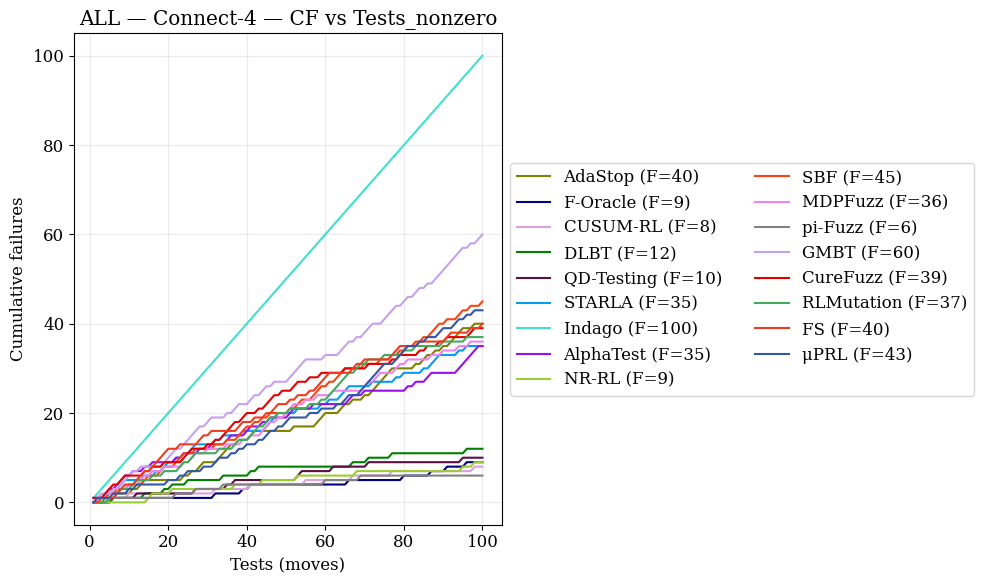

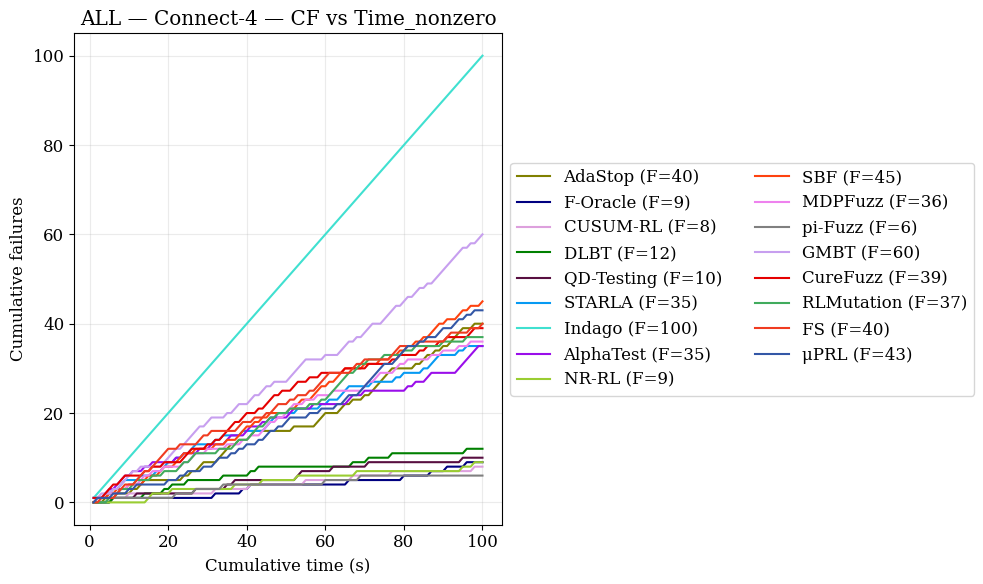

In [ ]:
FRAMEWORKS = [
    "AdaStop","F-Oracle","CUSUM-RL","DLBT","MDPMorph",
    "QD-Testing","STARLA","Indago","AlphaTest",
    "NR-RL","SBF","MDPFuzz","pi-Fuzz","GMBT","CureFuzz",
    "RLMutation","FS","μPRL",
]

df_cache = {fw: _canon(_safe_read(p)) for fw, p in RAW.items()}

def cumulative_curve(df, axis="tests"):
    y = df["failure"].to_numpy().cumsum()
    y = np.maximum.accumulate(y)
    if axis == "tests":
        x = np.arange(1, len(df) + 1)
    else:
        x = df["wall_dt"].to_numpy().cumsum()
    return x, y

def plot_all_solid(axis, nonzero_only, include_mapt, suffix):
    plt.figure(figsize=(10,6))
    plotted = 0
    for fw in FRAMEWORKS:
        if (not include_mapt) and fw == "MAPT-UF":
            continue
        dfw = df_cache.get(fw)
        if dfw is None:
            continue
        F = int(dfw["failure"].sum())
        if nonzero_only and F == 0:
            continue
        x, y = cumulative_curve(dfw, axis=axis)
        plt.plot(x, y, label=f"{fw} (F={F})", color=_col(fw), linestyle='-')
        plotted += 1

    plt.xlabel("Tests (moves)" if axis=="tests" else "Cumulative time (s)")
    plt.ylabel("Cumulative failures")
    plt.title(f"ALL — Connect-4 — CF vs {'Tests' if axis=='tests' else 'Time'}{suffix}")
    if plotted:
        plt.legend(loc="center left", bbox_to_anchor=(1,0.5), ncol=2)
    plt.grid(True, alpha=.25)
    plt.tight_layout()
    plt.show()
    plt.close()

plot_all_solid("tests", True, True, "_nonzero")
plot_all_solid("time",  True, True, "_nonzero")

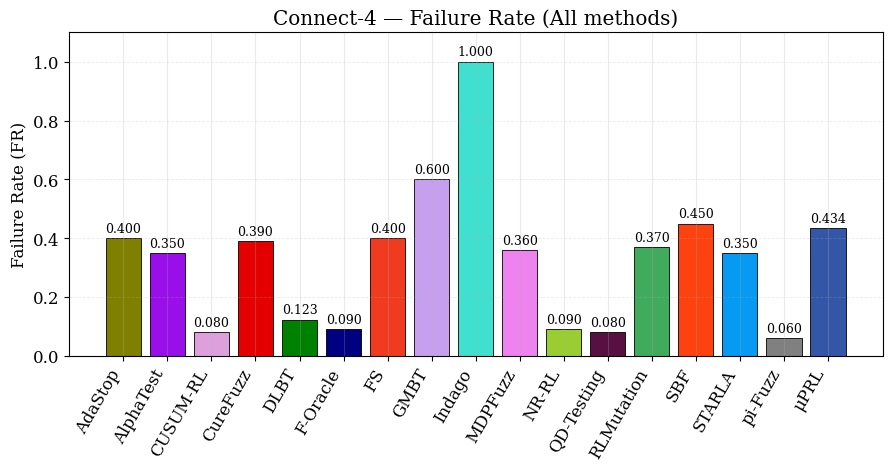

In [ ]:
# ---- Load FR per framework (merge cluster summaries) ----
def load_c4_fr():
    prefer = os.path.join(TABLES_DIR, "ALL_frameworks_metrics_c4_full.csv")
    if os.path.exists(prefer):
        df = pd.read_csv(prefer, keep_default_na=False)
        if {"framework","FR"}.issubset(df.columns):
            out = df.copy()
            out["FR"] = pd.to_numeric(out["FR"], errors="coerce")
            out["__prio"] = pd.Categorical(out.get("profile",""),
                    categories=["CLEAN(τ)","CLEAN","spec","repr","mutants_interleaved_1500"], ordered=True)
            out = out.sort_values(["framework","__prio"]).drop_duplicates("framework", keep="first")
            return out[["framework","FR"]]
    merged=[]
    for f in [Frameworks]:
        p = os.path.join(TABLES_DIR, f"{f}_summary_c4.csv")
        if os.path.exists(p):
            merged.append(pd.read_csv(p, keep_default_na=False))
    if not merged:
        raise FileNotFoundError("No Connect-4 summary tables found.")
    df = pd.concat(merged, ignore_index=True)
    df["FR"] = pd.to_numeric(df.get("FR", np.nan), errors="coerce")
    if "profile" in df.columns:
        df["__prio"] = pd.Categorical(
            df["profile"].fillna(""),
            categories=["CLEAN(τ)","CLEAN","spec","repr","mutants_interleaved_1500"], ordered=True
        )
        df = df.sort_values(["framework","__prio"]).drop_duplicates("framework", keep="first")
    return df[["framework","FR"]]

fr = load_c4_fr().sort_values("framework")
fr_all    = fr.copy()
fr_noMapt = fr[~fr["framework"].str.startswith("MAPT", na=False)].copy()


def plot_fr_bar(df, title, out_base):
    dd = df.copy()
    dd["FR"] = pd.to_numeric(dd["FR"], errors="coerce").fillna(0.0)
    dd = dd.sort_values("framework")
    plt.figure(figsize=(10.5,4.2))
    colors=[_col(f) for f in dd["framework"]]
    bars = plt.bar(dd["framework"], dd["FR"], color=colors, edgecolor='black', linewidth=0.6)
    plt.ylabel("Failure Rate (FR)")
    ymax = max(1.0, float(dd["FR"].max())*1.1 if len(dd) else 1.0)
    plt.ylim(0, ymax)
    plt.title(title)
    plt.xticks(rotation=60, ha="right")
    plt.grid(True, axis="y", alpha=.25, linestyle='--', linewidth=0.6)
    for b,val in zip(bars, dd["FR"]):
        plt.text(b.get_x()+b.get_width()/2, b.get_height()+0.01*ymax, f"{val:.3f}",
                 ha="center", va="bottom", fontsize=9)
    plt.show(); plt.close()

plot_fr_bar(fr_all,   "Connect-4 — Failure Rate (All methods)",  os.path.join(FIGS_DIR, "connect4_FR_all"))